In [91]:
from spectral_cube import SpectralCube
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import constants as const
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import regions
from astropy.io import fits
from astroquery.jplspec import JPLSpec
from astroquery.splatalogue import Splatalogue

In [84]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [85]:
import cutout_manager as cm
import moment_maker as mm

In [86]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


# Column Density Functions

In [3]:
# Citing https://ui.adsabs.harvard.edu/abs/2015PASP..127..266M/abstract 
# for how to use spectral line data to measure the column density of a given molecule

$
N^{thin}_{tot} = \left(\frac{3h}{8 \pi^3 S \mu^2 R_i}\right)
%\left( \frac{2J_u+1}{J_u}\right)
\left(\frac{Q_{rot}}{g_u}\right) %\\
%\times
\frac{\exp\left(\frac{E_u}{k_B T_{ex}}\right)}
{\exp\left(\frac{h \nu}{k_B T_{ex}}\right)-1} 
\times
%\int (1-exp(-\tau)) d\nu.
\int \frac{T_R d\nu}{f \left(J_\nu(T_{ex}) - J_\nu(T_{bg})\right)}
$

$N^{thin}_{tot}$ = column density of optically thin gas

$h$ = Planck constant

$Q_{rot}$ = rotational partition function

$g_u$ = degeneracy 

$E_u$ = upper energy level

$k_B$ = Boltzmann constant

$\nu$ = frequency

$R_i$ = 1 for $\Delta J=1$ transitions

$f$ = filling factor, assumed 1

$T_{ex}$ = excitation temperatrue

$\int T_R d\nu$ = integrated intensity

$T_{bg}$ = cosmic microwave background temperature 

$J_\nu(T)$ = planck function

$S = \frac{J_u}{2J_u+1}$ linear molecules where $J_u$ is the upper energy level

$\mu$ = electric dipole moment

In [102]:
# Planck Function for blackbody radiation
def planck(T, nu):
    return (const.h*nu/const.k_B)/(np.exp(const.h*nu/(const.k_B*T))-1)

In [103]:
def get_S(J):
    return J / (2*J + 1)

def get_Qrot(Tex, B):
    return (const.k_B * Tex) / (const.h * B) + 1/3 



## 12CO 1-0

In [46]:
response = JPLSpec.query_lines(min_frequency=100 * u.GHz,
                               max_frequency=1000 * u.GHz,
                               min_strength=-500,
                               molecule="28001 CO",
                               get_query_payload=False)
print(response)


    FREQ     ERR    LGINT   DR   ELO    GUP  TAG   QNFMT QN' QN"
    MHz      MHz   nm2 MHz      1 / cm                          
----------- ------ ------- --- -------- --- ------ ----- --- ---
115271.2018 0.0005 -5.0105   2      0.0   3 -28001   101   1   0
   230538.0 0.0005 -4.1197   2    3.845   5 -28001   101   2   1
345795.9899 0.0005 -3.6118   2   11.535   7 -28001   101   3   2
461040.7682 0.0005 -3.2657   2  23.0695   9 -28001   101   4   3
576267.9305 0.0005 -3.0118   2  38.4481  11 -28001   101   5   4
691473.0763 0.0005 -2.8193   2  57.6704  13 -28001   101   6   5
 806651.806  0.005 -2.6716   2  80.7354  15 -28001   101   7   6
   921799.7  0.005  -2.559   2 107.6424  17 -28001   101   8   7


In [60]:
CO1to0 = Splatalogue.query_lines(1*u.mm, 3*u.mm, chemical_name=' CO ', energy_type='eu_k', only_NRAO_recommended=True)

In [ ]:
# https://spec.jpl.nasa.gov/ftp/pub/catalog/doc/d028001.pdf

# dipole moment mu 
mu = 0.11011

# rotational constant B
B = 57635.968*u.MHz

# partition function Q_rot
Q_rot = get_Qrot(20*u.K, B)

# line strength S
S = get_S(1)

# frequency of the line
freq = response['FREQ'].to(u.GHz)[0]

# energy of the line
Eu = CO1to0[CO1to0['species_id'] == 204]['upper_state_energy_K'][0] * u.K

# degeneracy of the upper state
gu = response['GUP'][0]


$
N^{thin}_{tot} = \left(\frac{3h}{8 \pi^3 S \mu^2 R_i}\right)
%\left( \frac{2J_u+1}{J_u}\right)
\left(\frac{Q_{rot}}{g_u}\right) %\\
%\times
\frac{\exp\left(\frac{E_u}{k_B T_{ex}}\right)}
{\exp\left(\frac{h \nu}{k_B T_{ex}}\right)-1} 
\times
%\int (1-exp(-\tau)) d\nu.
\int \frac{T_R d\nu}{f \left(J_\nu(T_{ex}) - J_\nu(T_{bg})\right)}
$

In [118]:
def query_JLP(mol):
    response = JPLSpec.query_lines(min_frequency=100 * u.GHz,
                                   max_frequency=1000 * u.GHz,
                                   min_strength=-500,
                                   molecule=mol,
                                   get_query_payload=False)
    return response

def query_splat(mol):
    return Splatalogue.query_lines(1*u.mm, 3*u.mm, chemical_name=mol, energy_type='eu_k', only_NRAO_recommended=True, energy_max=50)[0]
    

# get column density of CO 1-0
def get_12CO_10_N(Tex, I, Ju=1):
    mu = (1.1079*10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
    B = 57635.968*u.MHz
    Q_rot = get_Qrot(Tex, B)
    S = get_S(Ju)
    Ri = 1
    f = 1
    jpl = query_JLP("28001 CO")
    freq = jpl['FREQ'].to(u.GHz)[Ju-1]
    splat = query_splat(' CO ')
    Eu = splat['upper_state_energy_K'] * u.K
    gu = jpl['GUP'][Ju-1]

    N = (3 * const.h * Q_rot)/(8 * np.pi**3 * S * mu**2 * Ri * gu) 
    N *= np.exp(Eu/(Tex))/(np.exp(const.h*freq/(const.k_B*Tex))-1) 
    N *= (f * (planck(Tex, freq)-planck(2.73*u.K, freq)))**(-1) 
    N = N*I
    return N # must multiply by I

## 13CO 1-0

In [30]:
response = JPLSpec.query_lines(min_frequency=100 * u.GHz,
                               max_frequency=1000 * u.GHz,
                               min_strength=-500,
                               molecule="29001 C-13-O",
                               get_query_payload=False)
print(response)

    FREQ     ERR    LGINT   DR   ELO    GUP  TAG   QNFMT QN' QN"
    MHz      MHz   nm2 MHz      1 / cm                          
----------- ------ ------- --- -------- --- ------ ----- --- ---
110201.3541 0.0051 -5.0662   2      0.0   3 -29001   101   1   0
220398.6765 0.0053 -4.1749   2   3.6759   5 -29001   101   2   1
330587.9601 0.0049 -3.6662   2  11.0276   7 -29001   101   3   2
440765.1668 0.0094 -3.3187   2  22.0549   9 -29001   101   4   3
550926.3029 0.0304 -3.0632   2  36.7572  11 -29001   101   5   4
661067.2801 0.0237 -2.8687   2  55.1341  13  29001   101   6   5
771184.1376 0.0402 -2.7187   2   77.185  15  29001   101   7   6
881272.8339 0.0627 -2.6034   2 102.9089  17  29001   101   8   7
991329.3479 0.0918 -2.5165   2  132.305  19  29001   101   9   8


In [ ]:
# https://spec.jpl.nasa.gov/ftp/pub/catalog/doc/d029001.pdf

# dipole moment mu
mu = 0.11046 

# rotational constant B
B = 55101.011*u.MHz

In [122]:
def get_13CO_10_N(Tex, I, Ju=1):
    mu = (1.1046*10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
    B = 55101.011 * u.MHz
    Q_rot = get_Qrot(Tex, B)
    S = get_S(Ju)
    Ri = 1
    f = 1
    jpl = query_JLP("29001 C-13-O")
    freq = jpl['FREQ'].to(u.GHz)[Ju-1]
    splat = query_splat(' 13CO ')
    Eu = splat['upper_state_energy_K'] * u.K
    gu = jpl['GUP'][Ju-1]

    N = (3 * const.h * Q_rot)/(8 * np.pi**3 * S * mu**2 * Ri * gu) 
    N *= np.exp(Eu/(Tex))/(np.exp(const.h*freq/(const.k_B*Tex))-1) 
    N *= (f * (planck(Tex, freq)-planck(2.73*u.K, freq)))**(-1)
    N = N*I

    return N.to(u.cm**(-2))

## C18O 1-0

In [31]:
response = JPLSpec.query_lines(min_frequency=100 * u.GHz,
                               max_frequency=1000 * u.GHz,
                               min_strength=-500,
                               molecule="30001 CO-18",
                               get_query_payload=False)
print(response)

    FREQ     ERR    LGINT   DR   ELO    GUP  TAG   QNFMT QN' QN"
    MHz      MHz   nm2 MHz      1 / cm                          
----------- ------ ------- --- -------- --- ------ ----- --- ---
109782.1734 0.0063 -5.0708   2      0.0   3 -30001   101   1   0
219560.3568 0.0081 -4.1794   2   3.6619   5 -30001   101   2   1
329330.5453  0.004 -3.6706   2  10.9857   7 -30001   101   3   2
439088.7631 0.0079 -3.3231   2   21.971   9 -30001   101   4   3
548830.9775 0.0329 -3.0675   2  36.6174  11 -30001   101   5   4
658553.2728 0.0234 -2.8728   2  54.9244  13  30001   101   6   5
 768251.589 0.0403 -2.7226   2  76.8914  15  30001   101   7   6
877921.9561 0.0633 -2.6071   2 102.5175  17  30001   101   8   7
987560.3837 0.0931 -2.5199   2 131.8018  19  30001   101   9   8


In [ ]:
# https://spec.jpl.nasa.gov/ftp/pub/catalog/doc/d030001.pdf 

# dipole moment mu
mu = 0.11079 

# rotational constant B
B = 54891.420*u.MHz

In [123]:
def get_C18O_10_N(Tex, I, Ju=1):
    mu = (1.1079*10**(-19) * u.esu * u.cm).to(u.cm*(u.cm**(3/2) * u.gram**(1/2) * u.second**(-1)))
    B = 54891.420 * u.MHz
    Q_rot = get_Qrot(Tex, B)
    S = get_S(Ju)
    Ri = 1
    f = 1
    jpl = query_JLP("29001 CO-18")
    freq = jpl['FREQ'].to(u.GHz)[Ju-1]
    splat = query_splat(' C18O ')
    Eu = splat['upper_state_energy_K'] * u.K
    gu = jpl['GUP'][Ju-1]

    N = (3 * const.h * Q_rot)/(8 * np.pi**3 * S * mu**2 * Ri * gu) 
    N *= np.exp(Eu/(Tex))/(np.exp(const.h*freq/(const.k_B*Tex))-1) 
    N *= (f * (planck(Tex, freq)-planck(2.73*u.K, freq)))**(-1) 
    N = N*I

    return N.to(u.cm**(-2))

# Integrated Intensity Maps

In [87]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
fn_13CO = '/orange/adamginsburg/cmz/nobeyama/13CO-2.FOREST.FITS'
fn_C18O = '/orange/adamginsburg/cmz/nobeyama/C18O-2.FOREST.FITS'

In [88]:
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
cube_13CO = SpectralCube.read(fn_13CO, format='fits')
cube_C18O = SpectralCube.read(fn_C18O, format='fits')

In [94]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

subcube_12CO = cube_12CO.subcube_from_regions([reg])
subcube_12CO = subcube_12CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_13CO = cube_13CO.subcube_from_regions([reg])
subcube_13CO = subcube_13CO.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_C18O = cube_C18O.subcube_from_regions([reg])
subcube_C18O = subcube_C18O.with_spectral_unit(u.km/u.s).spectral_slab(-57*u.km/u.s, -53*u.km/u.s)#(-56*u.km/u.s, -54*u.km/u.s)#

subcube_12CO_mom0 = subcube_12CO.moment0()
subcube_13CO_mom0 = subcube_13CO.moment0()
subcube_C18O_mom0 = subcube_C18O.moment0()

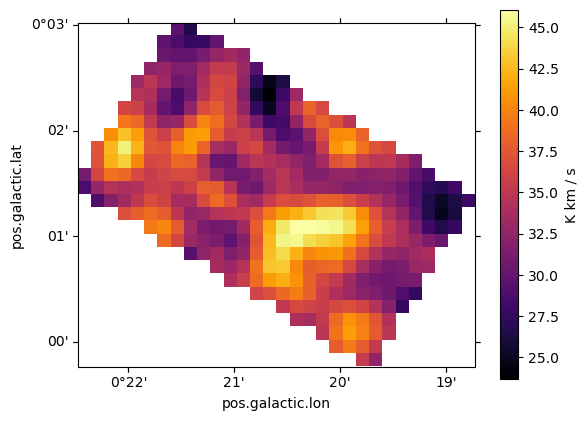

In [93]:
ax = plt.subplot(projection=subcube_12CO_mom0.wcs)
im = ax.imshow(subcube_12CO_mom0.value, origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, label=subcube_12CO_mom0.unit)

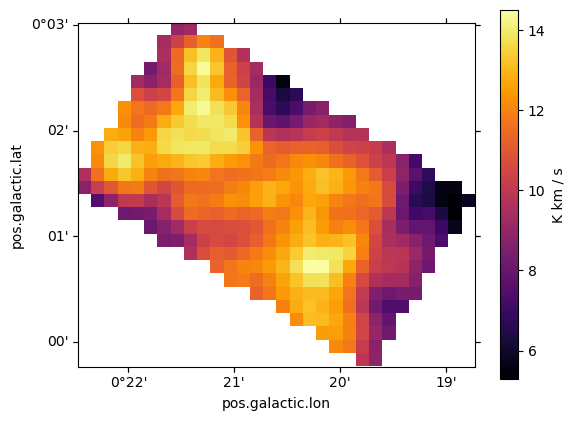

In [95]:
ax = plt.subplot(projection=subcube_13CO_mom0.wcs)
im = ax.imshow(subcube_13CO_mom0.value, origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, label=subcube_13CO_mom0.unit)

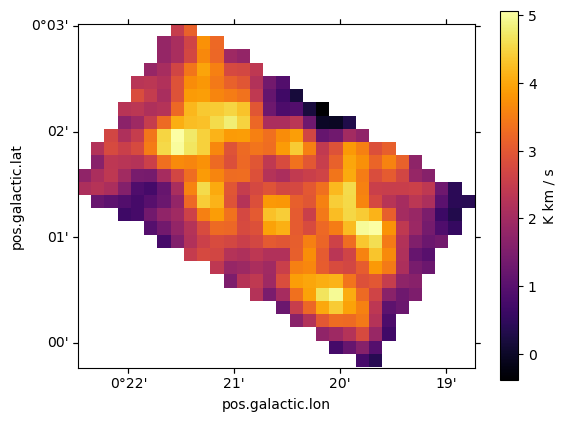

In [96]:
ax = plt.subplot(projection=subcube_C18O_mom0.wcs)
im = ax.imshow(subcube_C18O_mom0.value, origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, label=subcube_C18O_mom0.unit)

In [125]:
column_density_12CO = get_12CO_10_N(20*u.K, subcube_12CO_mom0)
column_density_13CO = get_13CO_10_N(20*u.K, subcube_13CO_mom0)
column_density_C18O = get_C18O_10_N(20*u.K, subcube_C18O_mom0)

In [132]:
co_abundance = 10**(-4)

In [135]:
ww = wcs.WCS(subcube_12CO_mom0.header)
N_12CO = np.nansum(column_density_12CO.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_12CO = N_12CO * pixel_physical_area * 2.8 * u.Da
M_12CO.to(u.M_sun) / co_abundance

<Quantity 0.12738478 solMass>

In [ ]:
ratio_12C_13C = 53 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_13CO_mom0.header)
N_13CO = np.nansum(column_density_13CO.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_13CO = N_13CO * pixel_physical_area * 2.8 * u.Da
M_13CO.to(u.M_sun) *ratio_12C_13C / co_abundance

<Quantity 2323.28420177 solMass>

In [ ]:
ratio_16O_18O = 327 # from Wilson & Rood 1994
ww = wcs.WCS(subcube_C18O_mom0.header)
N_C18O = np.nansum(column_density_C18O.value) * u.cm**(-2)
pixel_physical_area = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
M_C18O = N_C18O * pixel_physical_area * 2.8 * u.Da
M_C18O.to(u.M_sun) * ratio_16O_18O / co_abundance

<Quantity 3492.91941135 solMass>